<a href="https://colab.research.google.com/github/nakanoelio/i2a2-challenge-petr4-trad-sys/blob/main/I2A2_PETR4_Trading_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install yfinance
!pip install --upgrade mplfinance
 
#Instalação da Biblioteca TA-lib
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
!pip install pandas_ta

Requirement already up-to-date: mplfinance in /usr/local/lib/python3.7/dist-packages (0.12.7a17)
(Reading database ... 160798 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link



In [3]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sn
import matplotlib.pyplot as plt

import yfinance as yf

import talib as ta
import pandas_ta as pd_ta

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB

In [4]:
%matplotlib inline

In [5]:
stock_ticker = 'PETR4.SA'
start_date = '2016-01-26'
end_date = '2021-5-27'

yf_petr4 = yf.Ticker(stock_ticker)
df_petr4 = yf_petr4.history(start=start_date, end=end_date)

stock_ticker = '^BVSP'
yf_ibov = yf.Ticker(stock_ticker)
df_ibov = yf_ibov.history(start=start_date, end=end_date)

In [6]:
#Calculo dos Indicadores
def indicadores(stock_data):
    
    data = stock_data.copy()
    data['W%R'] = ta.WILLR(data['High'], data['Low'], data['Close'], timeperiod=14) #Retorna valor do indicador Williams %R
    data['MACD'], data['Signal-line'], data['Histograma_MACD'] = ta.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9) #Valores do indicador MACD
    data.loc[:, 'Momento_MACD']=np.where(data['Histograma_MACD']>0, 1, 0) #Retorna 1 para compra pelo MACD (momento positivo), 0 para venda
    data['Tendencia_MACD']=np.where(data['Histograma_MACD'].diff()>0, 1, 0) #Derivada, sinaliza reversao de tendencia no histograma MACD, 1 para compra, 0 para venda
    data.loc[:, 'W%R_Compra']= np.where(data['W%R']<-80, 1, 0) # Retorna 1 para sinal de compra, caso Williams %R < -80
    data.loc[:, 'W%R_Venda']= np.where(data['W%R']>-20, 1, 0)  # Retorna 1 para sinal de venda, caso Williams %R > -20

    data['Hammer']=ta.CDLHAMMER(data['Open'],data['High'], data['Low'], data['Close'])/100 #Sinal de compra pra martelo
    data['Shooting_star'] = ta.CDLSHOOTINGSTAR(data['Open'],data['High'], data['Low'], data['Close'])/-100 #Sinal de venda 'estrela cadente'
    #não sei como usar o donchian no modelo
    #data['DC_Lower'], data['DC_Medium'], data['DC_Higher'] = pd_ta.donchian(data["High"], data["Low"], lower_length=10, upper_length=15)
    data["EMA12"] =  ta.EMA(data["Close"], timeperiod=12)
    data["EMA26"] =  ta.EMA(data["Close"], timeperiod=26)
    #return data.drop(["Open","Close","High","Low","Volume","Dividends","Stock Splits"],axis="columns")
    return data[["EMA12","EMA26",'Signal-line','Histograma_MACD',]]#,"EMA12","EMA26",'W%R','MACD','Hammer','Shooting_star','Momento_MACD','Tendencia_MACD','W%R_Compra','W%R_Venda']]

In [7]:
def isSupport(df,i):
    #Estamos utilizando dados futuros!
    #support = df['Low'][i] <= df['Low'][i-1]  and df['Low'][i] <= df['Low'][i+1] and df['Low'][i] < df['Low'][i+2] and df['Low'][i] < df['Low'][i-2]
    #support = df['Low'][i-1] <= df['Low'][i-3]  and df['Low'][i-2] <= df['Low'][i-1] and df['Low'][i-2] < df['Low'][i] and df['Low'][i-2] < df['Low'][i-4]
    support = df['Low'][i] <= df['Low'][i-2]  and df['Low'][i-1] <= df['Low'][i-2] and np.abs(df['Low'][i]-df['Low'][i-1]) < np.abs(df['Low'][i-1]-df['Low'][i-2])
    
    return support

def isResistance(df,i):
    #Estamos utilizando dados futuros!
    #resistance = df['High'][i] > df['High'][i-1]  and df['High'][i] > df['High'][i+1] and df['High'][i] > df['High'][i+2] and df['High'][i] > df['High'][i-2]
    resistance = df['High'][i-2] > df['High'][i-3]  and df['High'][i-2] > df['High'][i-1] and df['High'][i-2] > df['High'][i] and df['High'][i-2] > df['High'][i-4]
    resistance = df['High'][i] > df['High'][i-2]  and df['High'][i-1] > df['High'][i-2] and np.abs(df['High'][i]-df['High'][i-1]) < np.abs(df['High'][i-1]-df['High'][i-2])
    
    return resistance 

In [8]:
def sup_res(df_data):
    s =  np.mean(df_data['High'] - df_data['Low'])
    levels = []
    support = [0,0]
    resistance = [0,0]
    for i in range(2,df_data.shape[0]-2):
        if isSupport(df_data,i):
            l = df_data['Low'][i]
            support.append(1)
            resistance.append(0)
            levels.append((i,l))
            #if isFarFromLevel(l,levels,s):
                #support.append(1)
                #resistance.append(0)
                #levels.append((i,l))
            #else:
                #support.append(0)
                #resistance.append(0)
        elif isResistance(df_data,i):
            l = df_data['High'][i]
            support.append(0)
            resistance.append(1)
            #if isFarFromLevel(l,levels,s):
                #resistance.append(1)
                #support.append(0)
                #levels.append((i,l))
            #else:
                #resistance.append(0)
                #support.append(0)
        else:
            resistance.append(0)
            support.append(0)
    support.extend([0,0])
    resistance.extend([0,0])

    return support, resistance

In [9]:
def feat_gen(data_f, p_window,return_period):
    
    data_frame = data_f.copy()

    #data_frame["Close_Return"] = data_frame["Close"].diff()
    data_frame["Close_Return_Rel"] = data_frame["Close"].pct_change()
    
    #data_frame["Close_Return"].fillna(0,inplace=True)
    #data_frame["Close_Return_Rel"].fillna(0,inplace=True)
    tresh = data_frame["Close_Return_Rel"].std()*0.05*return_period
    #tresh = 0
    data_frame.loc[data_frame["Close_Return_Rel"].rolling(return_period).sum() > tresh, "Expected_Close_Return"] = 1
    data_frame.loc[data_frame["Close_Return_Rel"].rolling(return_period).sum() < tresh, "Expected_Close_Return"] = 0
    data_frame.loc[data_frame["Close_Return_Rel"].rolling(return_period).sum() < -tresh, "Expected_Close_Return"] = -1
    #data_frame.loc[data_frame["Close_Return_Rel"].rolling(return_period).sum() >= tresh, f"Expected_Close_Return"] = 1
    #data_frame.loc[data_frame["Close_Return_Rel"].rolling(return_period).sum() < tresh, f"Expected_Close_Return"] = 0
   
    #new_col_names = []
 
    for i in range(0,p_window):
        
        data_frame[f'Return_Lag_{i}period'] = data_frame["Close_Return_Rel"].shift(periods=i)#.apply(lambda x: 1 if x >0 else 0)
        #data_frame[f'Return_Lag_{i}period'] = data_frame["Close_Return_Rel"].rolling(i+1).sum()
    
    data_frame["Expected_Close_Return"] = data_frame["Expected_Close_Return"].shift(-return_period)
    

    return data_frame.drop(["Open","Close","High","Low","Volume","Dividends","Stock Splits","Close_Return_Rel"],axis="columns").fillna(0)
    #return data_frame[["Expected_Close_Return"].fillna(0)

In [10]:
def calc_beta(data_frame_asset,data_frame_bench, beta_window):
    data_frame_beta = pd.concat([data_frame_bench["Close"].pct_change(), data_frame_asset["Close"].pct_change()],axis=1,ignore_index=True)

    data_frame_beta.columns=["Close_IBOV","Close_PETR4"]

    data_frame_beta["Beta"] = data_frame_beta["Close_PETR4"].rolling(beta_window).cov(data_frame_beta["Close_IBOV"].rolling(beta_window))/data_frame_beta["Close_IBOV"].rolling(beta_window).var()

    data_frame_beta["Beta_expected_PETR4"] = data_frame_beta["Close_IBOV"]*data_frame_beta["Beta"]

    data_frame_beta["PETR4_Excess_Variat"] = (data_frame_beta["Close_PETR4"] - data_frame_beta["Beta_expected_PETR4"])#/data_frame_beta["Beta_expected_PETR4"]
    #data_frame_beta["PETR4_Excess_Variat"].describe()
    #var_tolerance = 1#data_frame_beta["Close_IBOV"].std()#/data_frame_beta["Close_IBOV"].mean()

    #data_frame_beta.loc[data_frame_beta["PETR4_Excess_Variat"]  > var_tolerance, "PETR4_Excess_Variat_Disc"] = 1
    #data_frame_beta.loc[data_frame_beta["PETR4_Excess_Variat"] <= var_tolerance , "PETR4_Excess_Variat_Disc"] = 0
    #data_frame_beta.loc[data_frame_beta["PETR4_Excess_Variat"]  < -var_tolerance, "PETR4_Excess_Variat_Disc"] = 1
    

    #return data_frame_beta.drop(["Close_IBOV","Close_PETR4",], axis="columns").fillna(0)
    
    #return data_frame_beta["PETR4_Excess_Variat_Disc"].fillna(0)
    return data_frame_beta["PETR4_Excess_Variat"].fillna(0)

In [11]:
def gen_feat_data(data_frame_orig,p_window,return_period,data_frame_bench,beta_window):

    #df_feat = data_frame_orig
    df_feat = pd.concat([data_frame_orig, feat_gen(data_frame_orig, p_window, return_period)],axis=1)
    df_feat = pd.concat([df_feat,indicadores(data_frame_orig)],axis=1)
    sup,res = sup_res(data_frame_orig)
    df_feat["Support"] = sup
    df_feat["Resistance"] = res
    df_feat = pd.concat([df_feat,calc_beta(data_frame_orig,data_frame_bench,beta_window)],axis=1)
    df_feat = df_feat.reindex(columns=(list([col for col in df_feat.columns if col != "Expected_Close_Return"]+["Expected_Close_Return"])))
    df_feat = df_feat.drop(["Stock Splits","Dividends","Volume",'Open','High','Close','Low'],axis=1)

    return df_feat

In [12]:
def train_eval(df,train_init_date,train_end_date):#,test_end_date):
   
    dia_ini_train_idx = df.index.get_loc(train_init_date)
    dia_fin_train_idx = df.index.get_loc(train_end_date)
    #dia_fin_test_idx = df.index.get_loc(test_end_date)
    y_label_idx = df.columns.get_loc("Expected_Close_Return")
    X_tr = df.iloc[dia_ini_train_idx:dia_fin_train_idx].drop('Expected_Close_Return',axis='columns')
    X_ts = df.iloc[dia_fin_train_idx].drop('Expected_Close_Return')#,axis='columns')
    #print(X_ts)
    y_tr = df.iloc[dia_ini_train_idx:dia_fin_train_idx,y_label_idx]
    y_ts = df.iloc[dia_fin_train_idx,y_label_idx]

    return X_tr, X_ts, y_tr, y_ts

In [13]:
def run_model(X,y,model_type):
        
    nb_model = model_type
    nb_model.fit(X, y)

    
    
    #np.column_stack((y_test.to_list(),nb_model.predict(X_test)))
    #print(nb_model.predict_proba(X_test)[:10])
    #print(f'test_score = {nb_model.score(X_test,y_test)}')

    return nb_model

def meas_acc(X,y,nb_model):
    y_pred = nb_model.predict(X)
    print("Number of mislabeled points out of a total %d points : %d" % (X.shape[0], (y != y_pred).sum()))
    print("Train Accuracy: %f"% metrics.balanced_accuracy_score(y, y_pred))
    cf_train2 = metrics.confusion_matrix(y, y_pred, normalize="all")                                  
    sn.heatmap(cf_train2,linewidths=.5,annot=True,cmap="YlGnBu",cbar=False,square=True,xticklabels=(1,2,3), yticklabels=(1,2,3))

In [14]:
data_frame_orig = df_petr4
p_window = 2
beta_window = 30
data_frame_bench = df_ibov

return_period = 1
df_petr4_1 = gen_feat_data(data_frame_orig,p_window,return_period,data_frame_bench,beta_window).fillna(0)

return_period = 2
df_petr4_2 = gen_feat_data(data_frame_orig,p_window,return_period,data_frame_bench,beta_window).fillna(0)

return_period = 5
df_petr4_5 = gen_feat_data(data_frame_orig,p_window,return_period,data_frame_bench,beta_window).fillna(0)

return_period = 10
df_petr4_10 = gen_feat_data(data_frame_orig,p_window,return_period,data_frame_bench,beta_window).fillna(0)

In [15]:
df_petr4_10.describe()

,Return_Lag_0period,Return_Lag_1period,EMA12,EMA26,Signal-line,Histograma_MACD,Support,Resistance,PETR4_Excess_Variat,Expected_Close_Return
count,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000
mean,0.002010,0.002003,18.282388,18.129487,0.104154,0.000188,0.207704,0.267372,0.000250,0.245468
std,0.032733,0.032732,6.462955,6.538497,0.643282,0.216598,0.405817,0.442755,0.017302,0.872535
min,-0.296978,-0.296978,0.000000,0.000000,-3.781528,-1.466519,0.000000,0.000000,-0.163614,-1.000000
25%,-0.012991,-0.012991,13.568745,13.466081,-0.114666,-0.080931,0.000000,0.000000,-0.008082,-1.000000
50%,0.001588,0.001506,18.524603,18.379483,0.143746,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.016942,0.016942,23.794241,23.698315,0.442754,0.102474,0.000000,1.000000,0.008402,1.000000
max,0.222222,0.222222,29.376745,29.069992,1.470279,0.933574,1.000000,1.000000,0.116777,1.000000


Number of mislabeled points out of a total 65 points : 49
Train Accuracy: 0.438095


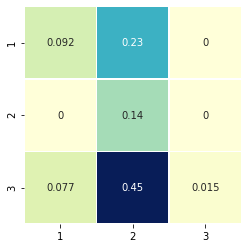

In [16]:
X,_,y,_ = train_eval(df_petr4_1,"2017-10-26 00:00:00","2018-01-26 00:00:00")
gnb1 = run_model(X,y, GaussianNB())
meas_acc(X,y,gnb1)

Number of mislabeled points out of a total 65 points : 25
Train Accuracy: 0.590541


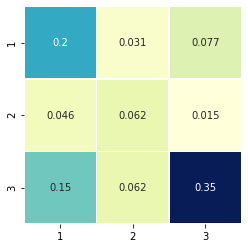

In [17]:
X,_,y,_ = train_eval(df_petr4_2,"2017-10-26 00:00:00","2018-01-26 00:00:00")
gnb2 = run_model(X,y, GaussianNB())
meas_acc(X,y,gnb2)

Number of mislabeled points out of a total 65 points : 14
Train Accuracy: 0.649471


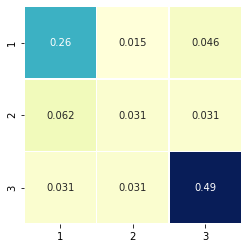

In [18]:
X,_,y,_ = train_eval(df_petr4_5,"2017-10-26 00:00:00","2018-01-26 00:00:00")
gnb5 = run_model(X,y, GaussianNB())
meas_acc(X,y,gnb5)

Number of mislabeled points out of a total 65 points : 15
Train Accuracy: 0.651614


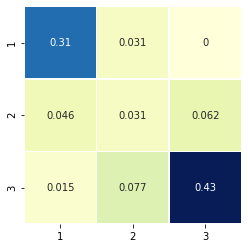

In [19]:
X,_,y,_ = train_eval(df_petr4_10,"2017-10-26 00:00:00","2018-01-26 00:00:00")
gnb10 = run_model(X,y, GaussianNB())
meas_acc(X,y,gnb10)

In [20]:
def rolling_results(df,dia_ini_train_idx,dia_ini_test_idx,model):
    results = []
    for i in df.iloc[dia_ini_train_idx:dia_ini_test_idx].index:
        X,X_test,y,y_test = train_eval(df,"2016-01-26 00:00:00",i)
        nb_model = run_model(X,y,model)
        y_predict = nb_model.predict(X_test.to_numpy().reshape(1, -1)).item()
        y_prob = nb_model.predict_proba(X_test.to_numpy().reshape(1, -1))
        results.append([i,y_test,y_predict]+list(y_prob[0]))
        
    return results, nb_model

In [21]:
dia_ini_train_idx = df_petr4_1.index.get_loc("2017-10-26 00:00:00")
dia_ini_test_idx = df_petr4_1.index.get_loc("2018-01-26 00:00:00")


In [22]:
res1,_ = rolling_results(df_petr4_1,dia_ini_train_idx,dia_ini_test_idx,GaussianNB())
res2,_ = rolling_results(df_petr4_2,dia_ini_train_idx,dia_ini_test_idx,GaussianNB())
res5,_ = rolling_results(df_petr4_5,dia_ini_train_idx,dia_ini_test_idx,GaussianNB())
res10,_ = rolling_results(df_petr4_10,dia_ini_train_idx,dia_ini_test_idx,GaussianNB())
print(res1)
print(res2)
print(res5)
print(res10)

[[Timestamp('2017-10-26 00:00:00'), 1.0, 0.0, 0.17223927684172255, 0.5782228568886457, 0.24953786626963148], [Timestamp('2017-10-27 00:00:00'), -1.0, 0.0, 0.20559773718642788, 0.5572682609285594, 0.23713400188501255], [Timestamp('2017-10-30 00:00:00'), 0.0, 0.0, 0.1879590710022893, 0.4873090815066254, 0.324731847491085], [Timestamp('2017-10-31 00:00:00'), 1.0, 0.0, 0.1998461215301582, 0.5806515281047055, 0.21950235036513607], [Timestamp('2017-11-01 00:00:00'), 0.0, 0.0, 0.2001717573510286, 0.5725767009942914, 0.22725154165468012], [Timestamp('2017-11-02 00:00:00'), 1.0, 0.0, 0.18196027832560846, 0.5984999791807362, 0.21953974249365527], [Timestamp('2017-11-03 00:00:00'), 1.0, 0.0, 0.18392225402740517, 0.5967590335953439, 0.21931871237725134], [Timestamp('2017-11-06 00:00:00'), -1.0, 0.0, 0.2397662107150572, 0.47414763273796195, 0.286086156546981], [Timestamp('2017-11-07 00:00:00'), 1.0, 1.0, 0.18670130058123163, 0.1446502695665251, 0.6686484298522433], [Timestamp('2017-11-08 00:00:00')

In [31]:
import statistics
trade_instruction = []
for i in range(len(res1)):
    media = np.mean([res1[i][2],res2[i][2],res5[i][2],res10[i][2]])
    if media>0:
        trade_instruction.append([res1[i][0],"Comprar"])
    elif media==0:
        trade_instruction.append([res1[i][0],"Manter"])
    elif media<0:
        trade_instruction.append([res1[i][0],"Vender"])
print(len(trade_instruction))

65


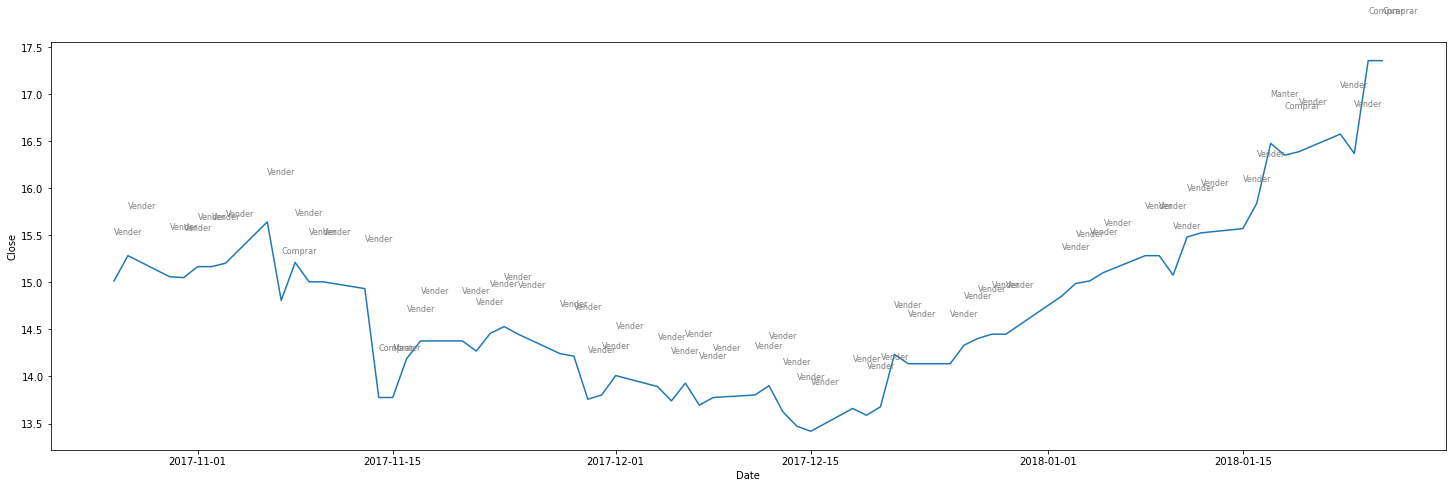

In [32]:
fig, ax = plt.subplots(figsize=(25, 7.5))
sn.lineplot(data=df_petr4["Close"].iloc[dia_ini_train_idx:dia_ini_test_idx],ax=ax)
style = dict(size=8, color='gray')
for i in range(len(trade_instruction)):
    ax.text(trade_instruction[i][0], df_petr4["Close"].iloc[dia_ini_train_idx:dia_ini_test_idx].iloc[i]+.5, trade_instruction[i][1],**style)

In [34]:
stock = 100
cash = 0
for i in range(len(trade_instruction)):

    if cash <=0 and stock <=0:
        print(i,stock,cash)
        break
    elif trade_instruction[i][1] == "Comprar":
        if cash > 0:
            stock += (cash/2)/df_petr4["Close"].loc[trade_instruction[i][0]]
            cash = cash/2
            print(i,stock,cash,"c")
        elif cash == 0 and stock > 0:
            
            pass
        elif cash <=0 and stock <=0:
            
            break
        print(i,stock,cash,"c")
    elif trade_instruction[i][1] == "Manter":
        print(i,stock,cash,"m")
        pass
    elif trade_instruction[i][1] == "Vender":
        if stock > 0:
            stock = 0.25*stock
            cash += (stock*.75)*df_petr4["Close"].loc[trade_instruction[i][0]]
            print(i,stock,cash,"v")
        elif cash > 0 and stock == 0:
            
            pass
        elif cash <=0 and stock <=0:
            
            break        
        print(i,stock,cash,"v")
    
print(i,stock,cash)


0 25.0 281.5334916114807 v
0 25.0 281.5334916114807 v
1 6.25 353.1789645552635 v
1 6.25 353.1789645552635 v
2 1.5625 370.8273947238922 v
2 1.5625 370.8273947238922 v
3 0.390625 375.2368723042309 v
3 0.390625 375.2368723042309 v
4 0.09765625 376.347787049599 v
4 0.09765625 376.347787049599 v
5 0.0244140625 376.625515735941 v
5 0.0244140625 376.625515735941 v
6 0.006103515625 376.6951122539467 v
6 0.006103515625 376.6951122539467 v
7 0.00152587890625 376.7130146632553 v
7 0.00152587890625 376.7130146632553 v
8 12.720845272239176 188.35650733162765 c
8 12.720845272239176 188.35650733162765 c
9 3.180211318059794 224.64088915525775 v
9 3.180211318059794 224.64088915525775 v
10 0.7950528295149485 233.58889569697058 v
10 0.7950528295149485 233.58889569697058 v
11 0.19876320737873712 235.8258973323988 v
11 0.19876320737873712 235.8258973323988 v
12 0.04969080184468428 236.3824719184744 v
12 0.04969080184468428 236.3824719184744 v
13 8.628838226137335 118.1912359592372 c
13 8.628838226137335 11